# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm, proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). The support webpage can be found here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm discovers the discords of arbitrary length in time series. It is worthwhile to note that the term arbitrary means the user can define a range for the length of discord (i.e. minimum length, `minL`, and maximum length, `maxL`). The algorithm finds discords of different lengths `L` $\in$ `[minL, maxL]`.

## What is a discord?
A subsequence of length `L` in a time series `T` is a discord **iff** it has the largest distance (hereafter being referred to as `discord_dist`) to its `[first]` nearest neighbor (`NN`). The neighbors of a subsequence of length `L`, starting at index `i`, is any other subsequences that start at an index `j`, such that `j!=i`. However, if `i` and `j` are very close to each other, the comparison between their corresponding subsequences is considered to be trivial. To this end, an exclusion zone (`excl_zone`) is taken into account to ignore the neighbors (i.e. subsequences) whose starting index is in numpy indexing `[i-excl_zone : i+excl_zone+1]`. 

**NOTE:** <br>
It is important to note that for the subsequenc `S = T[i:i+L]`, some of its neighbors are located on the left of `S` (i.e. the ones with starting index less than/equal to `max(0, i-excl_zone-1)`) and some of its neighbors are located on the right of `S` (i.e. the ones with starting index greater than/equal to `min(len(T), i+excl_zone+1)`). To find the `NN` of a subsequence `S`, the distance between `S` and all of its `[left and right]` neighbors must be obtained.

## Matrix Profile approach

How can we discover a discord of length `L` using matrix profile(`P`)? The solution is straightforward. `P` shows the distance of each subsequence to its `NN`. Therefore, the one that has the greatest distance to its `NN` is considered as the discord.

There are some advantages/disadvantages in using `P` when it comes to discovering discords:

* **Advantage:** <br>
Once we have the `P`, finding the discord is easy. Also, one can obtain the `top-k` discords very quickly by locating the first `k` largest distances in `P`.

* **Disadvantage:** <br>
`P` needs to be calculated for each new length `L` in `[minL, maxL]`, and, consequently, ALL pair-wise distances need to be calculated. Because, ALL pairwise distances are required for obtaining `P`. 

As will be shown later, `MERLIN` can skip some  of the pair-wise distance calculations. Also, it can use the `discord_dist` of length `L` to narrow down the search space for disovering the discord of length `L+1`.

## MERLIN

There are two main ideas at the core of the `MERLIN` algorithm. In below, we briefly explain each concept. Then, we will show its implementation and discuss its performance.

### Idea (1): Elimination Approach
The idea can be explained as follows: Suppose we are told that the discord distance (`discord_dist`) of length `L` is at least `min_dist` (Please note that the "how" of setting the `min_dist` value will be explained later in Idea(2)). That means the distance between the discord and each one of its neighbors is at least min_dist. We start scanning the subsequences. If, for a subsequence S, we realize that it has a neighbor to which its distance is smaller than `min_dist`, we can say S cannot be the discord. 

The main idea is to eliminate all subsequences for which there exist at least one neighbor with pair-wise distance less than `min_dist`. Therefore, the remaining subsequences (i.e. candidates) are the ones that have a distance great than/equal to `min_dist`. Now, we can find the `NN` of each candidate and choose the discord, i.e. the one that has the greatest distance to its `NN`. 

---

The smaller amount of candidates is the better. This is where choosing a good value for `min_dist` becomes important. For instance, let us consider two very extreme scenarios:

**Scenario I:** Choosing a VERY SMALL value for `min_dist`. In this case, we can end up with almost all subsequnces as the candidates.

**Scenario II:** Choosing a VERY LARGE value for `min_dist`. In this case, we can end up with no candidates at all. 

In below, we explain how MERLIN chooses the value for `min_dist`.

### Idea (2): Choosing `min_dist`
Let us assume we already discovered the discord `d` of length `L` whose distance to its NN (`d_NN`) is `discord_dist`. Now, to find the discord of length `L+1`, we can set `min_dist = discord_dist` if the distance is non-normalized Euclidean distance. The reason lies in the fact that increasing the length of subsequence results in an incease in the non-normalized Euclidean distance. In z-normalized Euclidean distance, however, increasing L may increase, decrease, or not change the distance. The authors of the [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf) paper suggested a way to update `min_dist` for `L+1` based on the findings in `L`. We recommend interested reader to read the paper to understand their suggested approach. In the current implementation, however, we use `min_dist = discord_dist` (similar to the non-normalized case) as impelemented in the newer version of MERLIN.

We also need a way to set the value of `min_dist` for the discord of length `L = minL` in the beginning of the algorithm. We cannot use the `discord_dist` as we haven't discovered any discord yet! In this case, we set `min_dist` to the maximum possible distance that can exist between two subsequences (please see below for the math!). Then, if we find no candidates (similar to the Scenario II above), we can reduce the `min_dist`. 

---

**NOTE: z-normalized and non-normalized Euclidean distance**<br>
Please note that the [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf) paper used z-normalized euclidean distance to calculate the distance between any two subsequence. In this work, our focus is on both normalized- and non-normalized- Euclidean distances. In the following, we will show how we can use dot product to calculate these two distances. Using dot product will help us to use the power of vectorization in the (more efficient) implementation of the  algorithm. Also, an inital value  for `min_dist` will be calculated that will be used in the beginning of the main (MERLIN) algorithm.

**z-normalizd Eucludiean distance ($ED_{z-norm}$):** <br>
$ED_{z-norm}$ and the Pearson correlation ($PC$), between any two subsequences with length $m$, are related as follows [(berthold2016)](https://arxiv.org/pdf/1601.02213.pdf):

$ED_{z-norm} = \sqrt{2 \times m \times (1-PC)}$ 

On the other hand, the $PC$ can be calculated as $PC = \frac{E[(X-\mu_{X})(Y-\mu_{Y})]}{\sigma_{X}\sigma_{Y}}$, which can be re-written as follows:

$PC = \frac{{\frac{1}{m}}{\sum\limits_{t=1}^{m}} {(X_{t} - \mu_{X})((Y_{t} - \mu_{Y}))}}{\sigma_{X}\sigma_{Y}}$.

Please note that a z-normalized subsequence has a mean ($\mu$) of 0 and standard deviation ($\sigma$) of 1. Therefore, the pearson correlation between two z-normalized subsequences becomes:

$PC = {\frac{1}{m}} <X_{z}, Y_{z}>$, where $<X_{z}, Y_{z}>$ is the dot product between two vectors $X_{z}$ and $Y_{z}$, where $X_{z}$ ($Y_{z}$) is a vector consists of the values of the subequene obtained by z-normalizing the subsequence $X$ ($Y$).


So, the first formula becomes: <br>
$ED_{z-norm} = \sqrt{2 \times m \times (1 - {\frac{1}{m}} <X_{z}, Y_{z}>)}$ 



Therefore, for a given $ED_{z-norm}$, one can calculate its corresponding dot product value as below: <br>
$<X_{z}, Y_{z}> = m \times (1 - \frac{1}{2m}{ED_{z-norm}^{2}})$ <br>
Thus, instead of comparing two z-normlized subsequences by calculating their (z-normlized) Euclidean distance, one can calculate the dot product of the two z-normalized subsequences. Please note that a higher z-normalized Euclidean distance means lower dot product value. So, instead of using `min_dist` as the minimum distance a discord's candidate should have with all of its neighbors, one can use `r`, where $r = m \times (1 - \frac{1}{2m}{min\_dist^{2}})$, as the maximum dot product value a discord's candidate should have with its neighbors.

**Initial value for $ED_{z-norm}$**: <br>
As discussed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf), the initial value for `min_dist` is set to its maximum possible value. This can be achieved by choosing the lowest value for $PC$ (i.e. -1). In that case, it can be observed that the initial value for `min_dist` is $2\sqrt{m}$.

---
**non-normalizd Eucludiean distance ($ED$):** <br>
$ED$ can still be calculated by the help of some dot products: <br>

$ED^{2} = {||X-Y||}^{2}  =  <X-Y , X-Y>  =  <X.X> + <Y.Y>  -  2<X,Y>$ <br>
Using the right hand side of the equation above may not make sense when we are iterating the subsequences in a for-loop one by one. However, in the more efficient version of MERLIN, where candidates are compared to more than one subsequencec in each iteration, this relationship can be helpful. We can calculate and store the two-norm of all subsequences in a 1-dim array. Then, we can use np.matmul() to calculate the last term (i.e. $<X,Y>$). We can get into further details later in the implementation.

**Initial value for $ED$**: <br>
Similar to the z-normalized case, we would like to set the value of the `min_dist` to the maximum possible value. Therefore:

$min\_dist^{2} = max ({||X-Y||}^{2}) = max \sum\limits_{t=1}^{m}(X_{t} - Y_{t})^{2} =  \sum\limits_{t=1}^{m}max{(X_{t} - Y_{t})^{2}} = \sum\limits_{t=1}^{m}{[max (|X_{t} - Y_{t}|)]}^{2} =  \sum\limits_{t=1}^{m}{(T_{max} - T_{min})^2} = {m} \times{(T_{max} - T_{min})^2}$

where, $T_{max}$ ($T_{min}$) is the maximum (minimum) value of the main time series $T$.

And, this gives the maximum possible value for `min_dist` as follows: <br>
$ min\_dist = (|T_{max} - T_{min}|) \sqrt{m}$

**NOTE:** Please note that, in practice, `T` might have infinite values. In that case, `min_dist` becomes infinite (and thus useless). To avoid this scenario, we should do: $T_{max} = np.max(T[np.isfinite(T)])$, and $T_{min} = np.min(T[np.isfinite(T)])$.

## Implement MERLIN
It is worthwhile to note that a faster version of MERLIN is provided on the MERLIN's support webpage [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies). However, for now, we implement the version proposed in the original paper as it can be implemented in a cleaner/more understandable way.

### Import libraries

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
from stumpy import core, config
import numpy as np
import matplotlib.pyplot as plt
import math
import time

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

### Import (toy) data
data set is available at: 
https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view


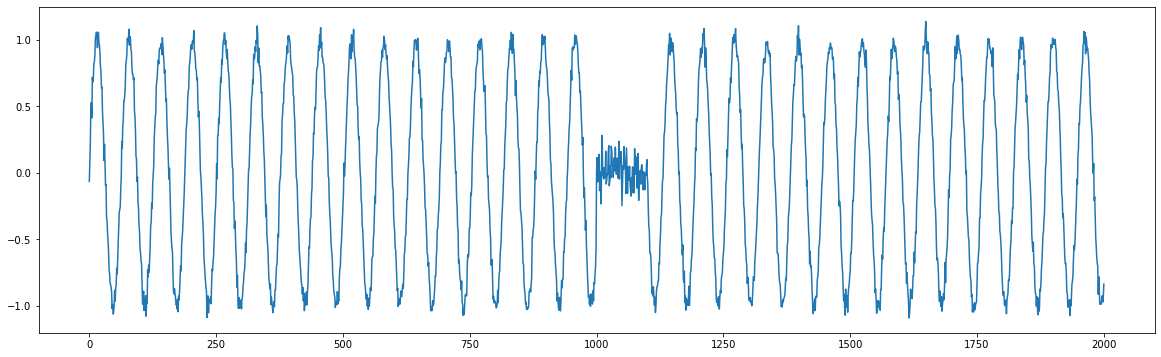

In [37]:
from scipy.io import loadmat

data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

#visualize data
plt.plot(ts)
plt.show()

As we can see there is an anomaly located in about the middle of the time series data. Next, we will implement and then use MERLIN to discover the discord.

### MERLIN- Part (I): DRAG --> Selecting Candidates  (then find discords) \[for discord of length L\]
As explained before, the idea is to select a number of candidates by eliminating undesirable subsequences. A candidate is a subsequence whose distance to all of its neighbors are at least `min_dist` (then, we can search among these candidates and find the discord) Since some neighbors of a subsequence is located on its left and others on its right, this part can be done in three phases as follows 

**MERLIN-Part(I): DRAG - Phase (I) --> Select Candidates** <br>
It is important to note that the term "candidates" in "select candidates" is different than the one we discussed so far. Here, some of the candidates (as will be explained shortly) might be false positive! That means, they HAVE a neighbor to which their distance is smaller than `min_dist`. These false positives will be pruned in the second phase of DRAG. 

In this phase, we compare each subsequence (i.e. potential candidate) with ALL of its RIGHT neighbors by calculating their dot product (instead of their euclidean distance). **NOTE:** We might end up with some false positives because we haven't check the LEFT neighbors YET. We compare each candidate with its LEFT neighbors in the second phase (to prune the false positives).

In [38]:
def _get_chunks_ranges(a):
    """
    This function takes an array that contains only integer numbers in ascending order, and return the
    (inclusive) start index and (exclusive) stop index of numbers for each continuous segment of array.
    
    Parameter
    --------
    a: numpy.ndarray
    1-dim numpy array that contains integer numbers in ascending order
    
    output
    -------
    out: numpy.ndarray
    a 2-dim numpy array. Each row contains the information about the start/stop index of a segment with continuous numbers.
    First columns gives the (inclusive) start index and second column gives the (exclusive) stop index of 
    continuous numbers in arr. 
    """
    repeats = np.full(len(a), 2)
    diff_is_one = np.diff(a) == 1
    repeats[1:] -= diff_is_one
    repeats[:-1] -= diff_is_one
    out = np.repeat(a, repeats).reshape(-1, 2)
    out[:, 1] += 1

    return out

In [69]:
def _select_candidates(T, m, M_T, Σ_T, T_subseq_isfinite, min_dist, include):
    """
    For a time series T, this function finds a set of candidates whose distance to all of their RIGHT neighbors is 
    at least min_dist. 
    
    Parameters
    ---------
    T : numpy.ndarray
    The time series or sequence from which to get top-k discords
    
    m : int
    Window size
    
    M_T: ndarray
    Sliding mean of `T`
    
    Σ_T: ndarray
    Sliding standard deviation of `T`
    
    T_subseq_isfinite: numpy.ndarray
    A boolean array that indicates whether a subsequence in `T` contains a
    `np.nan`/`np.inf` value (False)
    
    min_dist: scalar 
    the lowest z-normalized Euclidean distance that a discord should have with ALL of its neighbors. 
    
    NOTE: min_dist is passed to this function when it is called inside the main function MERLIN.
    
    include: ndarray
    is a 1-dim boolean array, with shape=(k,) where k is the total number of subsquences in the time series. 
    `include[i]` is True if the subsequence with start index `i` is eligible to be considered as one of the 
    prospective candidates. Therefore, if `include[i]` is False, `is_cands[i]` will be False as well.
    
    
    output
    --------
    is_cands: boolean numpy array
    is_cands[i] is True if i is the starting index of a candidate (may contain false positives! see Note below.)
    
    NOTE:
    (1) In this function, the selected candidates are gauranteed to have minimum distance of min_dist to 
    ALL of their RIGHT neighbors. Since we haven't checked them yet with their LEFT neighbors, some of the candidates 
    might be false positive, i.e. they have at least one LEFT neighbor to which their distance is less than min_dist.
    
    (2) Unlike the MERLIN paper where the exclusion zone is m, the default exclusion zone considered here
    is the STUMPY default config m/4. This can be changed by setting config.STUMPY_EXCL_ZONE_DENOM.
    """    
    n = T.shape[0] 
    k = n - m + 1 # number of subsequences
    
    is_cands = np.zeros(k, dtype=bool)
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    for i in np.flatnonzero(T_subseq_isfinite):
        add_cand_i = include[i] 
        
        if i > excl_zone:
            left_non_trivial_cand_idx = np.flatnonzero(is_cands[:i-excl_zone])
            cand_idx_chunks = _get_chunks_ranges(left_non_trivial_cand_idx) # get left_non_trivial cand indices in chunks
            for (start, stop) in cand_idx_chunks:
                Q = T[i:i+m]
                QT = core.sliding_dot_product(Q, T[start: (stop+m-1)])
                D = core._mass(Q, T[start: (stop+m-1)], QT, M_T[i], Σ_T[i], M_T[start:stop], Σ_T[start:stop])
                
                mask = np.flatnonzero(D < min_dist)   
                is_cands[start:stop][mask] = False

                if len(mask):
                    add_cand_i = False
        
        if add_cand_i:
            is_cands[i] = True
            
    return is_cands

In [70]:
#input (as provided by the  authors of paper)
m = 512 
min_dist = 10.27 #min_dist is not required for MERLIN. This is just to show the code works.

T_subseq_isfinite = core.rolling_isfinite(ts, m)
T, M_T, Σ_T = core.preprocess(ts, m)
include = np.ones(T.shape[0] - m + 1, dtype=bool)

In [71]:
is_cands = _select_candidates(T, m, M_T, Σ_T, T_subseq_isfinite, min_dist, include)
cand_index = np.flatnonzero(is_cands)
cand_index

array([ 584,  585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
        595,  596,  597,  598,  599,  600,  601,  602,  603,  604,  613,
        614,  615,  616,  617,  618,  619,  620,  621,  622,  623,  624,
        625,  626,  627,  628,  629,  630,  631,  632,  633,  634,  646,
        647,  648,  649,  650,  651,  652,  653,  654,  655,  656,  657,
        658,  659,  660,  661,  662,  663,  664,  665,  677,  678,  679,
        680,  681,  682,  683,  684,  685,  686,  687,  688,  689,  690,
        691,  692,  693,  694,  695,  696,  710,  711,  712,  713,  714,
        715,  716,  717,  718,  719,  720,  749,  750,  751,  780,  781,
        906,  907,  908, 1361, 1362, 1363, 1364, 1367, 1368, 1369, 1370,
       1371, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388,
       1393, 1394, 1395, 1396, 1400, 1401, 1402, 1403, 1404, 1405, 1406,
       1407, 1408, 1409, 1410, 1411, 1415, 1416, 1417, 1418, 1419, 1421,
       1422, 1423, 1424, 1425, 1426, 1427, 1428, 14

The number of so-far-selected candidates (188) are about one-tenth of total number of subsequences (1490). Also, some of them might be False Positives (that will be handled in the second phase.). 

Let's see if the anomaly part of the time series is covered by the selected candidates:

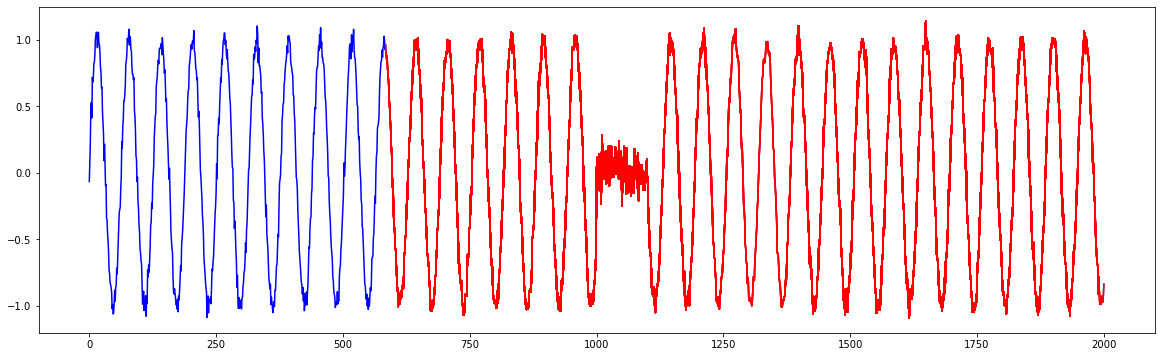

In [72]:
plt.plot(ts, c='b')
for idx in cand_index:
    plt.plot(np.arange(idx,idx+m), ts[idx:idx+m], c='r')
plt.show()

As illustrated, the selected candidates cover the anomaly. Next, we implement the second phase of DRAG, Prune Candidates, which is basically just comparing the selected candidates with their LEFT neighbors. 

**MERLIN-Part(I): DRAG - Phase (II) --> Prune Candidates**<br>
In this phase, we compare the selected candidate with their LEFT neighbors. The goal is to prune any candidate that has at least one left neighbor to which its distance is less than `min_dist`. So, at the end of this process, the remaining candidates are the ones that have a minimum distance of `min_dist` to all of their neighbors.

In [73]:
def _prune_candidates(T, m, M_T, Σ_T, T_subseq_isfinite, min_dist, is_cands):
    """
    For a time series T, this function prunes a set of candidates by comparing them with (all of) their LEFT neighbors. A
    selected candidate will be removed if it has at least one left neighbor to which its distance is less than `min_dist`. 
    
    Parameters
    ---------
    T : numpy.ndarray
    The time series or sequence from which to get top-k discords
    
    m : int
    Window size
    
    M_T: ndarray
    Sliding mean of `T`
    
    Σ_T: ndarray
    Sliding standard deviation of `T`
    
    T_subseq_isfinite: numpy.ndarray
    A boolean array that indicates whether a subsequence in `T` contains a
    `np.nan`/`np.inf` value (False)
    
    min_dist: scalar 
    the lowest z-normalized Euclidean distance that a discord should have with ALL of its neighbors. 
    
    NOTE: min_dist is passed to this function when it is called inside the main function MERLIN.
    
    is_cands: boolean numpy array
    the output of the function `_select_candidates`. 
    is_cand[i] is True if the subsequence starting at index i is selected as a candidate.
    
    
    output
    --------
    is_cands: boolean numpy array
    is_cands[i] is True if the subsequence with start index i is a candidate.
    
    NOTE:
    Any candidate chosen by this function is guaranteed to have minimum distance of min_dist to ALL of its LEFT neighbors.
    Therefore, if the argument is_cands is the output of _select_candidates, it can be guaranteed that any candidate
    returned by this function have minimum distance of min_dist to ALL of its neighbors.
    """    
    n = T.shape[0]
    k = n - m + 1 # number of subsequences
    
    cands_idx = np.flatnonzero(is_cands)
    
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
 
    for i in np.flatnonzero(T_subseq_isfinite):
        if np.all(is_cands == False):
            break
        
        non_trivial_cands = cands_idx[cands_idx > i + excl_zone] 
        
        if len(non_trivial_cands) == 0:
            break
        
        cand_idx_chunks = _get_chunks_ranges(non_trivial_cands)
        for (start, stop) in cand_idx_chunks:
            Q = T[i:i+m]
            QT = core.sliding_dot_product(Q, T[start: (stop+m-1)])
            D = core._mass(Q, T[start: (stop+m-1)], QT, M_T[i], Σ_T[i], 
                            M_T[start:stop], Σ_T[start:stop])
            
            mask = np.flatnonzero(D < min_dist)
            is_cands[start: stop][mask] = False
        
        
    return is_cands

In [74]:
is_cands = _prune_candidates(T, m, M_T, Σ_T, T_subseq_isfinite, min_dist, is_cands)
cands = np.flatnonzero(is_cands)
cands

array([592, 593, 594, 621, 622, 623, 624, 625, 626, 627, 652, 653, 654,
       655, 656, 657, 658, 659, 683, 684, 685, 686, 687, 688, 689, 690,
       691, 715, 716, 717, 718, 719, 720, 749, 750, 751, 780, 781, 906,
       907, 908], dtype=int64)

The number of final candidates (41) is about 3% of total number of subsequences (1490). In other words, out of the initial number of candidates (i.e. 1490), we just need to search among the 41 final candidates. We should note that choosing different values for `min_dist`can affect the performance of the algorithm (see Fig. 5 of the paper). For instance, choosing a very large value for `min_dist` may result in no candidates while choosing a very small value may result in a lot of candidates. Therefore, the algorithm should use a sound approach for adjusting `min_dist`. We will further discuss this matter when we implement the MERLIN algorithm itself. 

**Check if the dicord is covered by (some of) final candidates** <br>
Let us see if the anomaly part of the time series is covered by these final candidates:

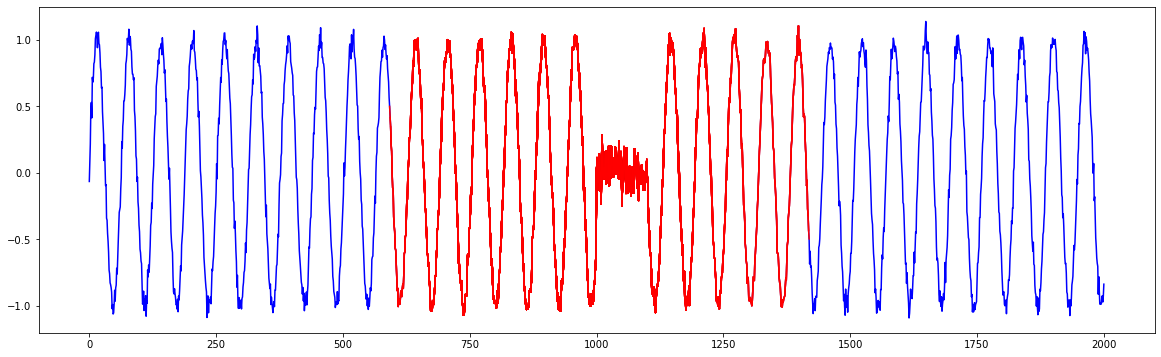

In [75]:
plt.plot(ts, c='b')
for idx in cands:
    plt.plot(np.arange(idx,idx+m), ts[idx:idx+m], c='r')
plt.show()

As illustrated in the figure above, the left candidate covers the anomaly of the time series data. Please note that it is possible that some of the candidates may not cover the anomaly. For example, recall the scenario where `min_dist` is very small. In that case, most subsequences are going to be returned as candidates. So, it is not reasonable to expect the most left and/or right candidates (and/or some other candidates) cover the anomaly in all cases. 

We can still find the discord! As will be shown in the next step,  we will find the NN of each of the final candidates, and choose the candidate that has the greatest distance to its NN. 

**MERLIN-Part(I): DRAG - Phase (III) --> Find Discord**<br>
After pruning the false positive candidates, we can find the NN of each of the remaining candidates. The candidate that has the greatest distance to its NN is the (top) discord.

In [76]:
def _find_discord(T, m, M_T, Σ_T, is_cands):
    """
    For a time series T, this function finds the discord by searching among the chosen candidates.
 
    Parameters
    ---------
    T : numpy.ndarray
    The time series or sequence from which to get top-k discords
    
    m : int
    Window size
    
    M_T: ndarray
    Sliding mean of `T`
    
    Σ_T: ndarray
    Sliding standard deviation of `T`
    
    is_cands: boolean numpy array
    the output of the function `_select_candidates`. 
    is_cands[i] is True if i is the starting index of a candidat
    
    
    output
    --------
    discord_idx: int 
    the index of the discord
    
    discord_dist: float
    the distance of the discord to its nearest neighbor
    
    discord_NN_idx: int
    the index of the discord's nearest neighbor
    """    
    cands = np.flatnonzero(is_cands)
    
    n = T.shape[0]
    k = n - m + 1 # number of subsequences
    
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    #initialize outputs 
    discord_idx = -1
    discord_dist = np.NINF
    discord_nn_idx = -1
    
    for idx in cands:
        Q = T[idx:idx+m]
        QT = core.sliding_dot_product(Q, T)
        D = core._mass(Q, T, QT, M_T[idx], Σ_T[idx], M_T, Σ_T)
        
        core.apply_exclusion_zone(D, idx, excl_zone, val=np.inf)

        nn_idx = np.argmin(D) 
        
        if D[nn_idx] > discord_dist:
            discord_idx = idx
            discord_dist = D[nn_idx]
            discord_nn_idx = nn_idx
               
    
    return discord_idx, discord_dist, discord_nn_idx

In [77]:
discord_idx, discord_dist, discord_nn_idx = _find_discord(T, m, M_T, Σ_T, is_cands)

print('the index of discord is: ', discord_idx)
print('dist of discord to its NN is: ', discord_dist)
print('the index of NN of the discord: ', discord_nn_idx)

the index of discord is:  718
dist of discord to its NN is:  10.301397123538989
the index of NN of the discord:  278


**Now, let us use matrix profile (of stumpy package) to make sure the output of MERLIN-Part(I) is correct:**

In [78]:
mp = stumpy.stump(ts, m)
P = mp[:,0] #p: matrix profile (dist of each subseq to its NN)

mp_discord_idx = np.argmax(P)
mp_discord_dist = P[mp_discord_idx]
mp_discord_nn_idx = mp[mp_discord_idx,1]

print('>>> using matrix profile to find the discord <<< \n')
print('the index of discord is: ', mp_discord_idx)
print('dist of discord to its nn is: ', mp_discord_dist)
print('the index of nn of the discord: ', mp_discord_nn_idx)

>>> using matrix profile to find the discord <<< 

the index of discord is:  718
dist of discord to its nn is:  10.30139712353895
the index of nn of the discord:  278


### Finding `top-k` Discords (of length L)

In some cases, one might be interested in finding more than one discord. The authors of [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf) referred readers to the paper [DiskawareDiscords](https://www.cs.ucr.edu/~eamonn/DiskawareDiscords.pdf) for `top-k` discords. However, the paper [DiskawareDiscords](https://www.cs.ucr.edu/~eamonn/DiskawareDiscords.pdf) does not take into account the `excl_zone` when it tries to find the `top-k` discords. In other words, it can return the subsequences at `idx` and `idx+1` as the `top-2` discords! But, this is not a correct approach as the two discovered discords are the trivial match of each other! As one can observe in the MATLAB implementation of MERLIN provided in [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies), the `k-th` discord index should not be in the `exclusion area` of the previous `k-1` discords.

**With matrix profile `P`:** <br>
we can easily find the `top-k` discords by finding the largest value in `P` and store its index `idx`. Then, assigning `np.NINF` to the exlcusion area of `idx`, that is: 
`P[idx-excl_zone: idx+excl_zone+1] = np.NINF`. And, then find the largest value in the updated array `P`. `k` iterations of the same process can give us the `top-k` discords.


**With MERLIN:**

In `MERLIN`, however, the `top-discord` is discovered by searching among some candidates rather than calculating the complete matrix profile. Therefore, to find `top-k`, we need to have (**enough**) candidates. For instane, suppose we are looking for `top-2` discords of length `100` in the time series `T` (`excl_zone=25` based on STUMPY default config). 

If, at the end of the second phase of MERLIN-Part(I), `cands = np.flatnonzero(is_cands)` contains only one index, say, `50`, that means we can just find the `top-discord` and we cannot find the second one as we don't have more candidates. The same thing is true if our `cands` ONLY contains `[50, 51, 52]`. Becuase, after finding the `top-discord` (e.g. `52`) and eliminating the candidates whose indices are in the exclusion area of `top-discord`, we are left with an empty `cands`. 

On the other hand, if `cands` contains `[50, 200]`, we can easily find the `top-2` discords in our first attempt as finding the `top-discord` doesn't lead to the elimination of the other candidate in this case. Please note that `[50, 200]` is still not enough if we are interested in `top-k` with `k>2`.  

**NOTE** <br>
As we will see shortly below, we do not check if we can get more than one discord from a set of candidates (at one attempt). **Instead,** we just find one discord, and then go through the whole process again to get the next one. Therefore, we go through the whole process of `select candidate -> prune candidate -> find discord` to find each discord of `top-k` !!! Please see below for more details. This approach is similar to the MATLAB implementation. I think the reason for getting only one discord (in each iteration of whole process) is that the candidates are probably close to each other for a good choice of `min_dist`. Therefore, if we find a discord from a set of candidates, the remaining candidates are probably in trivial match with the chosen discord. So, it might be better to not waste time searching for another discord on the same set of candidates, and instead, start the whole process again!

**> To find `top-k` discords** <br>
Let us assume we already discovered the the first `i` discords. We can find the discord `i+1 -th` (of the same length) as follows: <br>
(1) reduce `min_dist` (so we can get more candidates!) <br> 
(2) get candidates by `_select_candidates`function. <br>
(3) remove the previously-discovered discord starting index and their trivial matches from the current set of candidates <br> 
(4) update candidates by pruning the false positive ones using `_prune_candidates` function. <br> 
(5) Find the `top-discord` by using `_find_discord` function. <br> 

In [79]:
def _murlin(T, m, min_dist, n_discords=1, decay = None, include = None):
    """
    For a time series T, this function finds `top-k` discords.
    
    Parameters
    ---------
    T : numpy.ndarray
    The time series or sequence from which to get top-k discords
    
    m : int
    Window size
    
    min_dist: scalar 
    the lowest z-normalized Euclidean distance that a discord should have with ALL of its neighbors. 
    
    NOTE: min_dist is passed to this function when it is called inside the main function MERLIN.
    
    n_discords: int
    number of discords to be discovered.
    
    decay: numpy.ndarray
    a 1-dim array of length n_discords with values each between 0 and 1. 
    The decay[i] represents the rate of decrease of min_dist for i-th discord. 
    
    include: ndarray
    is a 1-dim boolean array, with shape=(k,) where k is the total number of subsquences in the time series. 
    `include[i]` is True if the subsequence with start index `i` is eligible to be considered as one of the 
    prospective candidates. Therefore, if `include[i]` is False, `is_cands[i]` will be False as well. 
    When include=None (default), all the elements of `include` are set to True.
    
    
    output
    --------
    out: ndarray
    is a n_discords-by-3 array. i-th row cosists of information of i-th discord.
    First column is the discord index. Second column is the distance of discard to its Nearest Neighbor. 
    And, third column is the index of discord's NearestNeighbor.
        
    NOTE: 
    Please note that the rate of change of `min_dist`, originally proposed in the paper, was constant. 
    However, as authers stated, the choice is not science-backed. The challenge is that a failed attempt may not be 
    resolved by reducing min_dist in small steps. Therefore, in this implementation, we increase the rate of change 
    (in a linear manner) when we get a failed attempts. Therefore, we can quickly hit a point where we get at least 
    one candidate (at the end of second phase).
    """ 
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    T = T.copy()
    T = np.asarray(T)
    core.check_dtype(T)
    n = T.shape[0]
    
    if T.ndim == 2 and T.shape[1] == 1:  # pragma: no cover
        T = T.flatten()

    if T.ndim != 1:  # pragma: no cover
        raise ValueError(f"T is {T.ndim}-dimensional and must be 1-dimensional. ")
    
    if (n <= (m + excl_zone)):  # pragma: no cover
        raise ValueError(
            f"The length of `discord` ({m}) is too big. Make sure"
            f"the sum of `discord_length` and `excl_zone` ({m + excl_zone})"
            f"is less than  length of `T` ({len(T)})."
        )
    
    T_subseq_isfinite = core.rolling_isfinite(T, m)
    T, M_T, Σ_T = core.preprocess(T, m)
    
    if decay is None:
        decay = np.full(n_discords, 0.05)
        decay[0] = 0.01
    
    if np.any((decay <= 0) | (decay >= 1)):
        raise ValueError("All values of array decay must be bigger than 0 and less than 1.")
    
    k = n - m + 1 # number of subsequences
    if include is None: 
        include = np.ones(k, dtype=bool)
        
    if include.shape != (k, ):
        raise ValueError(f"The shape of include must be {(k,)}, where n is the total number of subsequences")
    
    is_infinite_discords = np.logical_and(~T_subseq_isfinite, include)
    
    include[~T_subseq_isfinite] = False
    
    discords_idx = np.full(n_discords, -1, dtype=np.int64)
    discords_dist = np.full(n_discords, np.NINF, dtype=np.float64)
    discords_nn_idx = np.full(n_discords, -1, dtype=np.int64)
     
    for i in range(n_discords):
        if np.all(include==False):
            break
        
        # The following if-block should be un-commented later ...
        # ... when we modify _find_discord to return all possibe discords instead of just one discord
        #if min_dist == 0: 
        #    break 
        
        max_attempts = int(np.ceil(1.0 / decay[i])) + 1
        min_distances = min_dist * (1 - np.arange(max_attempts) * decay[i])
        min_distances = np.clip(min_distances, a_min=0.0, a_max=None)
        
        for min_dist in min_distances:
            is_cands = _select_candidates(T, m, M_T, Σ_T, T_subseq_isfinite, min_dist, include)
            is_cands = _prune_candidates(T, m, M_T, Σ_T, T_subseq_isfinite, min_dist, is_cands)
            
            if np.any(is_cands): 
                break
        
        discords_idx[i], discords_dist[i], discords_nn_idx[i] = _find_discord(T, m, M_T, Σ_T, is_cands)
        core.apply_exclusion_zone(include, discords_idx[i], excl_zone, val=False) ##update `include`
    
    out = np.empty((n_discords, 3), dtype = object)
    out[:, 0] = discords_idx
    out[:, 1] = discords_dist
    out[:, 2] = discords_nn_idx
    
    
    return out, is_infinite_discords

In [80]:
tic = time.time()
out, is_infinite_discords = _murlin(T, m, min_dist=10.27, n_discords=10)
toc = time.time()
print('running time: ', toc-tic)
print('------------------------')
print('infinite discords: \n', np.flatnonzero(is_infinite_discords))
print('\n')
print('finite discords: \n', out)

running time:  34.7261426448822
------------------------
infinite discords: 
 []


finite discords: 
 [[718 10.301397123538989 278]
 [906 10.271812911147375 1283]
 [589 10.24593756887557 149]
 [1035 8.487378272524355 1412]
 [1182 2.2518328767163376 114]
 [309 2.2364873593726973 1377]
 [154 2.230473678559099 1348]
 [1348 2.230473678559099 154]
 [1479 2.2014556687631655 285]
 [5 2.1913006977345946 382]]


**Now, let us see the results of `_murlin` when the time series has `np.nan`/`np.inf` values:**

In [81]:
T_noisy = np.copy(T)
T_noisy[100:200] = np.inf

tic = time.time()
out_noisy, is_infinite_discords_noisy = _murlin(T_noisy, m, min_dist=10.27, n_discords=10)
toc = time.time()
print('running time: ', toc-tic)
print('------------------------')
print('infinite discords: \n', np.flatnonzero(is_infinite_discords_noisy))
print('\n')
print('finite discords: \n', out_noisy)

running time:  28.486915111541748
------------------------
infinite discords: 
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


finite discords: 
 [[592 10.309001435762784 215]
 [750 10.276715760289077 1127]
 [906 10.27181291114738 1

**NOTEs** <br>
(1) Please note that MERLIN and MERLIN3_1 provide the (same) implementation for `top-k` discords. MERLIN3 does NOT provide an implementation for discovering `top_k` discords. 

(2) Please note that the complete implementation of MERLIN can discover discords of different length in `[minL, maxL]`. The current implementation of `murlin` is for when `min_dist` is provided by the user and not the weak bound `2*sqrt(m)`. (We will see later that there will be some small changes when we wan to implement the complete MERLIN.)

(3) If an attamp fails (i.e. no candidates are being returned after the second phase- `_prune_candidates`), we need to lower the `min_dist` to let more candidates be discovered. **While MATLAB implementation uses a fixed value (0.99 or 0.95) for rate of change of `min_dist`, we, in this implementation, increase `the rate of change` as we get more and more failed attempts.** Getting failed attemeps is a sign that tells us `min_dist` needs to be lower. While we can use the same rate of change, we should better increase the rate of change (i.e. reducing `min_dist` faster), so we can quickly find a value of `min_dist` that results in at least one canddidates.

**Let us use matrix profile to find `top-k` discords**

In [51]:
def stumpy_top_k_discords(T, m, n_discords = 1):
    """
    This funciton use stumpy package to find the `top-k` discords, of length m, in time series ts.
    
    Parameters
    ---------
    T : numpy.ndarray
    The time series or sequence from which to get top-k discords
    
    m : int
    Window size
        
    n_discords: int
    number of discords to be discovered.
    
    output
    --------
    out: ndarray
    is a n_discords-by-3 array. i-th row cosists of information of i-th discord.
    First column is the discord index. Second column is the distance of discard to its Nearest Neighbor. 
    And, third column is the index of discord's NearestNeighbor.
    """
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))
    
    mp = stumpy.stump(T, m)
    P = mp[:,0].astype(np.float64) #change the dtype to np.float64, so it can be used later in core.apply_exclusion_zone
    
    discords_idx = np.full(n_discords, -1, dtype=np.int64)
    discords_dist = np.full(n_discords, np.NINF, dtype=np.float64)
    discords_nn_idx = np.full(n_discords, -1, dtype=np.int64)
    
    for i in range(n_discords):
        mp_discord_idx = np.argmax(P)
        
        discords_idx[i] = mp_discord_idx
        discords_dist[i] = P[mp_discord_idx]
        discords_nn_idx[i] = mp[mp_discord_idx,1]
        
        core.apply_exclusion_zone(P, discords_idx[i], excl_zone, val=np.NINF)
    
    out = np.empty((n_discords, 3), dtype = object)
    out[:, 0] = discords_idx
    out[:, 1] = discords_dist
    out[:, 2] = discords_nn_idx
    
    return out

In [52]:
mp_out = stumpy_top_k_discords(ts, m, n_discords = 10)
mp_out

array([[718, 10.30139712353895, 278],
       [906, 10.271812911147359, 1283],
       [589, 10.245937568875583, 149],
       [1035, 8.48737827252434, 1412],
       [1182, 2.2518328767162363, 114],
       [309, 2.236487359372494, 1377],
       [154, 2.2304736785590227, 1348],
       [1348, 2.2304736785590227, 154],
       [1479, 2.2014556687629847, 285],
       [5, 2.191300697734569, 382]], dtype=object)

As observed, the outputs of `murlin` and `stumpy_top_k_discords` are the same in finding the `top-k` (`k=10`) discords (please see below).

In [53]:
#compare the output of murlin and stumpy_top_k_discord
np.testing.assert_almost_equal(mp_out, out)

### MERLIN- Part (II): merlin --> Find Discords of arbitrary lenght (between minL and maxL)
Now, we are at a position to implement merlin, which basically iterates through the three-phase of MERLIN-Part(I) process and find the discords. The advantage of merlin is that it uses the result of `m = L` to initialize `min_dist` for `m = L+1`.

In [165]:
def murlin(T, min_L=3, max_L=3, max_k=1, min_dist=None, decay_init_value=None, decay=None):
    """
    This funciton finds `top-k` discords for each length m in [min_L: max_L+1]
    
    Parameters
    ---------
    T : numpy.ndarray
    The time series or sequence from which to get top-k discords
    
    min_L : int
    minimum Window size 
    
    max_L : int
    maximum Window size
    
    max_k: int
    maximum number of discords to discover.
    
    min_dist: scalar
    a minimum distance that a discord must have with all of its neighbors. The default is None as the algorithm
    finds it on its own. However, if an expert user knows its domain and can make a guess, it can feed it to the 
    algorithm.
    
    decay_init_value: scalar
    a value between 0 and 1 that is used as the rate of decrease of min_dist when finding the topmost discord 
    of smallest legnth `min_L`
    
    decay: numpy.ndarray
    a 1-dim array of length k (number of discords) with values each between 0 and 1. 
    The decay[i] represents the rate of decrease of min_dist for i-th discord.
    
    output
    --------
    out: ndarray
    is a k-by-4 array. each row stores information of one discord.
    First column is the discord index. Second column is the distance of discard 
    to its Nearest Neighbor. Third column is the index of discord's NearestNeighbor. 
    Fourth column is the length of discord (m).
    
    For two discords stored at row-index i and row-index j (i<j), the discord at i has shorter or equal length 
    than the discord j. If the length of two discords are the same, the one at row-index i has larger distance to its NN
    compared to the one at row-index j.
    
    
    
    NOTE:
    Please note that higher values for decay may lead to a faster discovery 
    of candidates; however, it can result in a large set of candidates which can slow down the process. 
    In contrast to the original study, where min_dist is getting reduced by a constant factor C, the current implementation
    uses a linear function to increase C when we get a failed attempt in discovering discords. This decision is made to make 
    a sound trade-off between the time required to find at least one candidate and the number of selected candidates.
    
    NOTE:
    The paper's methodogy focused on z-normalized Euclidean distance as the distance measure of choice between two 
    subsequences. However, in the future version, a support for non-normalized Euclidean distance will be added to 
    the merlin tool.
    
    NOTE:
    To ignore trival matches, the original paper used a full window size m. However, this implementation uses the default 
    STUMPY setting of m/4.
    
    Ref:
    DOI: 10.1109/ICDM50108.2020.00147
    """    
    if min_dist is None:
        min_dist = 2 * np.sqrt(min_L) #this is for z-normalizd Euclidean Distance. 
    
    if decay_init_value is None:
        decay_init_value = 0.2 #originally, it was a "constant" factor 0.5
        
    if decay is None:
        decay = np.full(max_k, 0.05)
        decay[0] = 0.01
    decay_init = np.copy(decay)
    decay_init[0] = decay_init_value
    
    out = np.empty(shape=(0,4), dtype=object)
    for m in range(min_L, max_L+1):
        print(f'{m}', end='-->')
        if m == min_L:
            top_k_discords = _murlin(T, m, min_dist, max_k, decay_init)           
        else:
            min_dist = top_k_discords[0,1] #i.e. use "topmost" discord distance from previous stage
            top_k_discords = _murlin(T, m, min_dist, max_k, decay) 
            
        n_discords = top_k_discords.shape[0] 
        out = np.concatenate( (out, np.c_[top_k_discords, np.full(n_discords, m)]), axis=0)
    print('Done!\n')
    
    
    return out

**NOTE** <br>
There are a few differences between the MERLIN proposed in the original paper and the implementation `merlin` provided above. The differences are as follows:
* The original paper used a constant rate of change for reducing `min_dist`. However, we use a varaible rate of change. In the current implementation, the higher number of failed attempts results in a higher reduction in `min_dist`.


* The original paper MERLIN's and MERLIN3.1's have the same approach in updating `min_dist`, and it is different than what provided in MERLN3. In MERLIN3, the `min_dist` for discord of length `m` is initially set to the topmost `discord_dist` of discord with length `m-1`. However, in MERLIN and MERLIN3.1, the authors considered a different (informal) approache. For discords of lenght $m \in [min_L+1,min_L+4]$, the `min_dist` for topmost discord is initially set to `discord_dist` of discord with length `m-1`. However, for $m >= min_L+5$, the `min_dist` for topmost discord is initially set to $\mu - 2\delta$, where $\mu$ is the average of topmost discord distance for discords with length `m-1`, `m-2`, `m-3`, `m-4`, and `m-5` (i.e. 5 previous topmost discords), and $\delta$ is their standard deviation. The idea behind such approach is that z-normalized Euclidean distance between two subsequences with length `L` may be higher than/lower than/equal to the distance between subseqeunces of length `L-1`. So, if we just assign the `discord_dist` of discord with length `m-1` to the initial value of `min_dist` of discsord with length `m`, we MIGHT get a `min_dist` that  is too great or too small. The authors claimed that $min\_dist = \mu - 2\delta$ is a better guess for `min_dist` when using normalized Euclidean distance. 
(**NOTE:** The implementation of `merlin` function in this notebook follows the approach provided in MERLIN3.)

In [166]:
T = ts; min_L = 510; max_L = 515;
discords = murlin(T, min_L, max_L, max_k=5)
discords

510-->511-->512-->513-->514-->515-->Done!



array([[719, 10.287049451580202, 279, 510],
       [908, 10.258958295132217, 1285, 510],
       [590, 10.238572791078084, 150, 510],
       [1037, 8.469796875930564, 1414, 510],
       [1182, 2.246630226872049, 365, 510],
       [719, 10.29539669780288, 1096, 511],
       [908, 10.265015473458387, 1285, 511],
       [590, 10.248613802549292, 150, 511],
       [1037, 8.470219572531068, 1414, 511],
       [1182, 2.2487293472710643, 365, 511],
       [718, 10.301397123538989, 278, 512],
       [906, 10.271812911147375, 1283, 512],
       [589, 10.24593756887557, 149, 512],
       [1035, 8.487378272524355, 1412, 512],
       [1182, 2.2518328767163376, 114, 512],
       [718, 10.30785591445074, 278, 513],
       [906, 10.277811266083457, 1283, 513],
       [588, 10.2445461092826, 148, 513],
       [1036, 8.480311101655634, 1413, 513],
       [1182, 2.256146945410831, 114, 513],
       [718, 10.312916271244426, 278, 514],
       [906, 10.283153403344029, 1283, 514],
       [588, 10.254718746

In [167]:
def stumpy_discords(T, min_L, max_L, max_k=1):
    """
    This funciton use stumpy package to find the `top-k` discords for each length m in [min_L: max_L+1]
    
    Parameters
    ---------
    T : numpy.ndarray
    The time series or sequence from which to get top-k discords
    
    min_L : int
    minimum Window size 
    
    max_L : int
    maximum Window size
        
    max_k: int
    maximum number of discords to be discovered.
    
    output
    --------
    out: ndarray
    is a k-by-4 array. each row stores information of one discord.
    First column is the discord index. Second column is the distance of discard 
    to its Nearest Neighbor. Third column is the index of discord's NearestNeighbor. 
    Fourth column is the length of discord (m).
    
    For two discords stored at row-index i and row-index j (i<j), the discord at i has shorter or equal length 
    than the discord j. If the length of two discords are the same, the one at row-index i (i.e. lower index) has larger distance to its NN
    compared to the one at row-index j.
    """
    out = np.empty(shape=(0,4), dtype=object)
    
    for m in range(min_L, max_L+1):
        discords = stumpy_top_k_discords(T, m, max_k)
        top_k_discords = discords[discords[:,0]>=0] #to ignore the ones with original fill_value -1 as discord index
        
        n_discords = top_k_discords.shape[0] 
        out = np.concatenate( (out, np.c_[top_k_discords, np.full(n_discords, m)]), axis=0)
    
    
    return out

In [168]:
#compare the output of merlin and stumpy_discords
mp_discords = stumpy_discords(T, min_L, max_L, max_k=5)
np.testing.assert_almost_equal(mp_discords, discords)